Overview: Credit card fraud detection using anomaly detection. We use a local outlier factor to calculate anomaly scores, as well as an isolation force algorithm. 2,80,000 credit card transactions --> predict which ones are fraudulent.

keywords: Unsupervised ML, anomaly detection, outlier detection.

*dataset from kaggle: https://www.kaggle.com/datasets/mlg-ulb/creditcardfraud

# Credit Card Fraud Detection

In [2]:
import sys
import scipy

In [3]:
# Import the necessary packages
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

In [5]:
# Load the dataset

data = pd.read_csv('creditcard.csv')

In [6]:
# Exploring the data
# already anonymized and reduced by PCA!

print(data.columns)

Index(['Time', 'V1', 'V2', 'V3', 'V4', 'V5', 'V6', 'V7', 'V8', 'V9', 'V10',
       'V11', 'V12', 'V13', 'V14', 'V15', 'V16', 'V17', 'V18', 'V19', 'V20',
       'V21', 'V22', 'V23', 'V24', 'V25', 'V26', 'V27', 'V28', 'Amount',
       'Class'],
      dtype='object')


In [7]:
print(data.shape)

(284807, 31)


In [8]:
print(data.describe())
# class attribute is the target (classifying transactions as fraudulent or valid --> 
# mean is close to 0 means we have many more valid transactions!)
## 1 is fraud, 0 is valid

                Time            V1            V2            V3            V4  \
count  284807.000000  2.848070e+05  2.848070e+05  2.848070e+05  2.848070e+05   
mean    94813.859575  3.918649e-15  5.682686e-16 -8.761736e-15  2.811118e-15   
std     47488.145955  1.958696e+00  1.651309e+00  1.516255e+00  1.415869e+00   
min         0.000000 -5.640751e+01 -7.271573e+01 -4.832559e+01 -5.683171e+00   
25%     54201.500000 -9.203734e-01 -5.985499e-01 -8.903648e-01 -8.486401e-01   
50%     84692.000000  1.810880e-02  6.548556e-02  1.798463e-01 -1.984653e-02   
75%    139320.500000  1.315642e+00  8.037239e-01  1.027196e+00  7.433413e-01   
max    172792.000000  2.454930e+00  2.205773e+01  9.382558e+00  1.687534e+01   

                 V5            V6            V7            V8            V9  \
count  2.848070e+05  2.848070e+05  2.848070e+05  2.848070e+05  2.848070e+05   
mean  -1.552103e-15  2.040130e-15 -1.698953e-15 -1.893285e-16 -3.147640e-15   
std    1.380247e+00  1.332271e+00  1.23709

In [9]:
data = data.sample(frac = 0.1, random_state = 1)

print(data.shape)

(28481, 31)


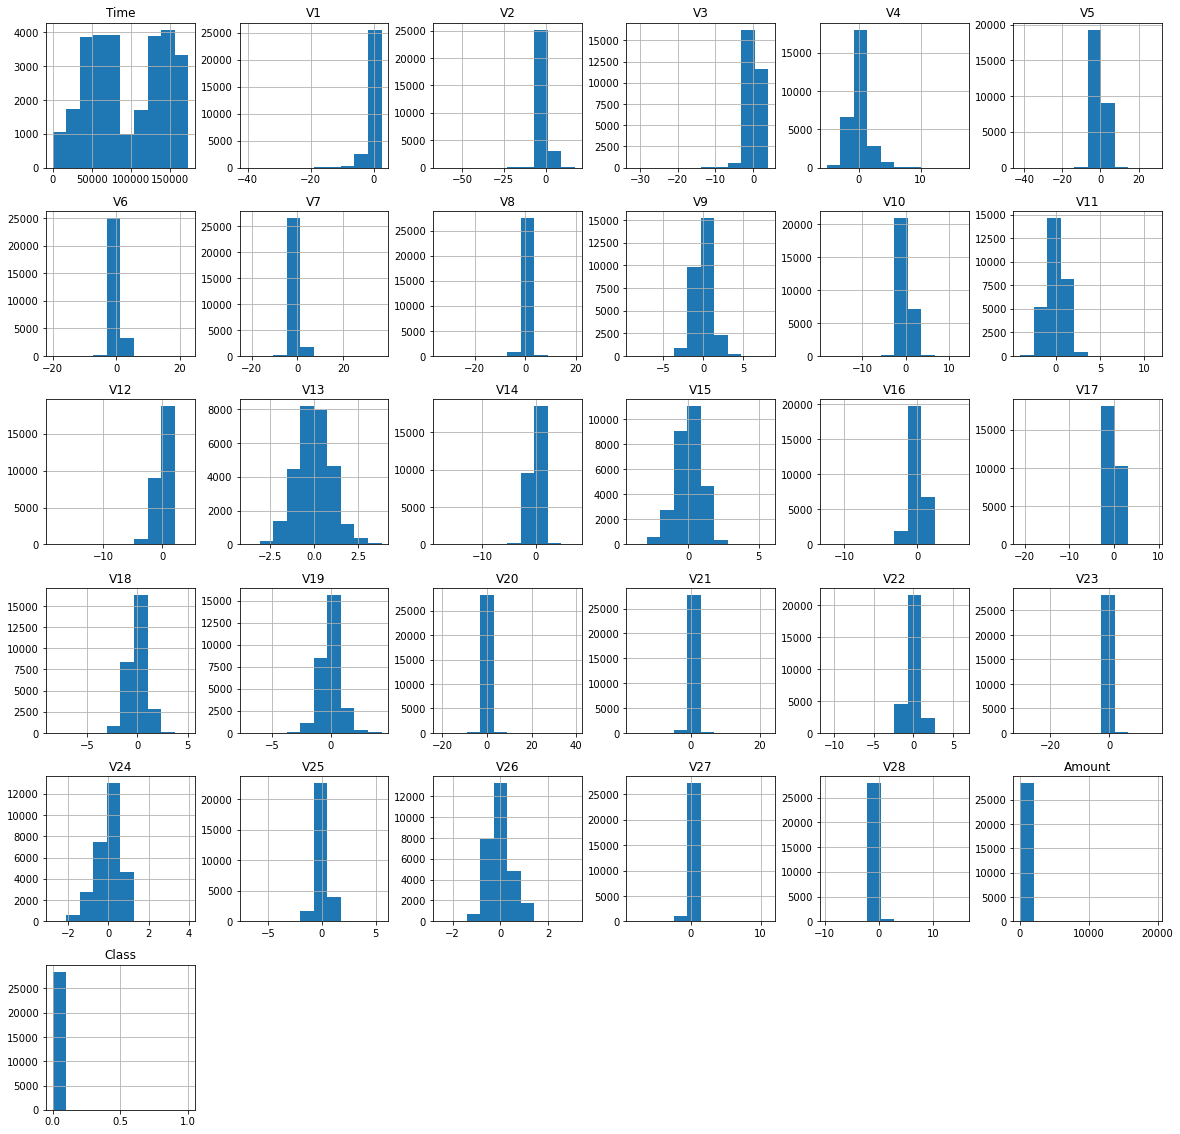

In [10]:
# Plotting histograms of each parameter

data.hist(figsize=(20,20))
plt.show()

In [14]:
# determine the fraud cases
Fraud = data[data['Class'] == 1]
Valid = data[data['Class'] == 0]

outlier_fraction = len(Fraud) / float(len(Valid)) ##typecasting to avoid rounding off to 0
print(outlier_fraction)

print('Fraudulent cases {}'.format(len(Fraud)))
print('Valid cases {}'.format(len(Valid)))

## Fraud cases are very less!!

0.0017234102419808666
Fraudulent cases 49
Valid cases 28432


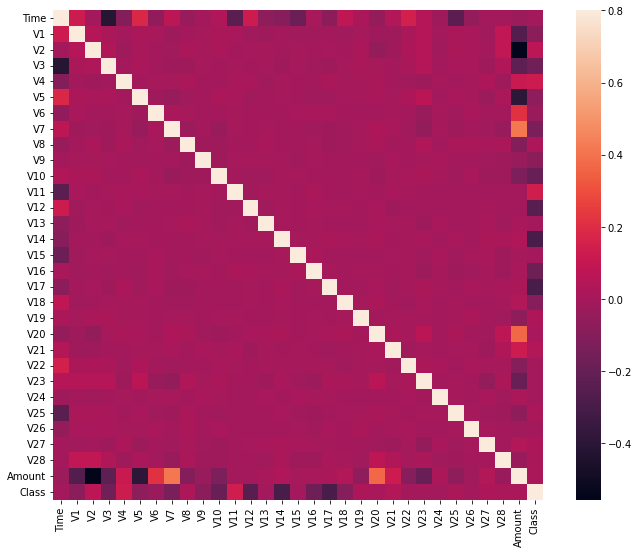

In [12]:
# Try to see if strong relationships exist between attributes

corr_matrix = data.corr()
fig = plt.figure(figsize = (12,9))
sns.heatmap(corr_matrix, vmax = .8, square = True) ## equal axes

plt.show()
## no 1-to-1 relationships!

In [13]:
# Get column list
columns = data.columns.tolist()

# Filter the columns to remove the data we don't want to use
columns = [c for c in columns if c not in ['Class']]

# Define target to predict on
target = 'Class'

X = data[columns]
Y = data[target]

#Print shapes of X and Y
print(X.shape)
print(Y.shape)

(28481, 30)
(28481,)


## Anomaly detection

In [17]:
from sklearn.metrics import classification_report, accuracy_score
from sklearn.ensemble import IsolationForest
from sklearn.neighbors import LocalOutlierFactor

## SVM takes much longer for large dataset (like here) 
## LocalOutlierFactor is an unsupervised outlier detection method. Calculates the anomaly score of each sample.
## (Measures the local deviation of density of a given sample wrt its neighbors --> similar to KNNs)

## IsolationForest returns the anomaly score of each sample. It isolates the observations by randomly selecting a 
## features then randomly selecting a split value between the max/min values of the selected feature (across columns).
## Since recursive partitioning can be represented by a tree structure, the number of splittings required to isolate is = 
## the path length from the root node to the terminating node. (remember algorithms & data structures)
## The path length here as an average over all the trees is a measure of normality and our decision function. 
## So, if trees produce consistently shorter paths for a sample, then it's highly likely to be an anomaly. 
## https://www.analyticsvidhya.com/blog/2021/07/anomaly-detection-using-isolation-forest-a-complete-guide/

# Define a random state
state = 1

#  Define the outlier detection methods
classifiers = {
    "Isolation Forest": IsolationForest(max_samples= len(X), 
                                        contamination= outlier_fraction,
                                        random_state = state),
    
    ## the higher the %age of outliers in our data, the more no. of neighbors we need to consider
    "Local Outlier Factor": LocalOutlierFactor(n_neighbors= 20, 
                                              contamination= outlier_fraction)
    
}


In [18]:
# Fitting the model

n_outliers = len(Fraud)

for i, (clf_name, clf) in enumerate(classifiers.items()):
    
    # fit the data and tag outliers
    if clf_name == "Local Outlier Factor":
        y_pred = clf.fit_predict(X)
        scores_pred = clf.negative_outlier_factor_
        
    else:
        clf.fit(X)
        scores_pred = clf.decision_function(X)
        y_pred = clf.predict(X)
        
    ## y_pred gives -1 for outlier, 1 for inlier
    
    # Reshape the prediction because class labels --> {0,1}
    y_pred[y_pred == 1] = 0
    y_pred[y_pred == -1] = 1 ##outliers
    
    # Calculating error in prediction by comparison withh target 'Y'
    n_errors = (y_pred != Y).sum()
    
    # Run classification metrics
    print('{} : {}'.format(clf_name, n_errors))
    print(accuracy_score(Y, y_pred))
    print(classification_report(Y, y_pred))
    
    ## precision of only 0.02 (precision = TP/TP+FP) which means out of the available fraud cases, only very few were getting predicted 
    ## fraud in reality (accounts for false positives)
    ## recall accounts for false negatives (recall = TP/TP+FN)
    
    ## isolationforest a bit better than local outlier factor
    

C:\Users\mitus\anaconda3\lib\site-packages\sklearn\base.py:450: UserWarning: X does not have valid feature names, but IsolationForest was fitted with feature names
  warnings.warn(


Isolation Forest : 71
0.99750711000316
              precision    recall  f1-score   support

           0       1.00      1.00      1.00     28432
           1       0.28      0.29      0.28        49

    accuracy                           1.00     28481
   macro avg       0.64      0.64      0.64     28481
weighted avg       1.00      1.00      1.00     28481

Local Outlier Factor : 97
0.9965942207085425
              precision    recall  f1-score   support

           0       1.00      1.00      1.00     28432
           1       0.02      0.02      0.02        49

    accuracy                           1.00     28481
   macro avg       0.51      0.51      0.51     28481
weighted avg       1.00      1.00      1.00     28481



** Note: taking a larger fraction of the dataset would give better results (likely), but it is computationally very expensive!